a. Capture 25 paquetes de su red doméstica (no de la red de la UVG) y asígnelos a una variable.

b. Imprima el tipo de variable, la longitud y el contenido de la variable.

c. Imprima el tipo de dato del primer paquete capturado.

d. Imprima el contenido de 5 paquetes

In [2]:
from scapy.all import sniff
#25 paquetes
paquetes = sniff(count=25)

print("Tipo de variable:", type(paquetes))

print("Cantidad de paquetes capturados:", len(paquetes))
print("Contenido de los paquetes:")
print(paquetes)

print("Tipo del primer paquete:", type(paquetes[0]))

print("Contenido de los primeros 5 paquetes:")
for i in range(5):
    print(f"\nPaquete {i+1}:")
    print(paquetes[i].summary())


Tipo de variable: <class 'scapy.plist.PacketList'>
Cantidad de paquetes capturados: 25
Contenido de los paquetes:
<Sniffed: TCP:7 UDP:18 ICMP:0 Other:0>
Tipo del primer paquete: <class 'scapy.layers.l2.Ether'>
Contenido de los primeros 5 paquetes:

Paquete 1:
Ether / IPv6 / UDP 2607:f8b0:4008:813::200a:https > 2800:98:1122:1389:595:e7f7:9c32:218f:57064 / Raw

Paquete 2:
Ether / IPv6 / UDP 2800:98:1122:1389:595:e7f7:9c32:218f:57064 > 2607:f8b0:4008:813::200a:https / Raw

Paquete 3:
Ether / IP / TCP 192.168.1.23:65203 > 52.182.143.210:https PA / Raw

Paquete 4:
Ether / IP / TCP 192.168.1.23:65203 > 52.182.143.210:https A / Raw

Paquete 5:
Ether / IP / TCP 192.168.1.23:65203 > 52.182.143.210:https PA / Raw


Descargue e archivo analisis_paquetes.pcap y asignelo a una variable.

In [ ]:
from scapy.all import rdpcap

paquetes = rdpcap("analisis_paquetes.pcap")


Convierta la variable a un DataFrame.

In [ ]:
import pandas as pd

datos = []

for pkt in paquetes:
    if pkt.haslayer("IP"):
        src_ip = pkt["IP"].src
        dst_ip = pkt["IP"].dst
        src_port = pkt.sport if hasattr(pkt, 'sport') else None
        dst_port = pkt.dport if hasattr(pkt, 'dport') else None
        datos.append({
            "Src Address": src_ip,
            "Dst Address": dst_ip,
            "Src Port": src_port,
            "Dst Port": dst_port
        })

df = pd.DataFrame(datos)


Muestre el contenido de las primeras 5 filas del dataset.

In [5]:
df.head()

,Src Address,Dst Address,Src Port,Dst Port
0,10.1.10.53,84.54.22.33,53,53
1,84.54.22.33,10.1.10.53,53,53
2,10.1.10.53,84.54.22.33,53,53
3,84.54.22.33,10.1.10.53,53,53
4,10.1.10.53,84.54.22.33,53,53


Muestre los valores de las columnas: Src Addres, Dst Address, Src Port y Dst Port.

In [6]:
df[["Src Address", "Dst Address", "Src Port", "Dst Port"]].head()

,Src Address,Dst Address,Src Port,Dst Port
0,10.1.10.53,84.54.22.33,53,53
1,84.54.22.33,10.1.10.53,53,53
2,10.1.10.53,84.54.22.33,53,53
3,84.54.22.33,10.1.10.53,53,53
4,10.1.10.53,84.54.22.33,53,53


Mostrar todas las IP origen

In [7]:
ip_origenes = df["Src Address"].unique()
print("Todas las IP origen:")
print(ip_origenes)


Todas las IP origen:
['10.1.10.53' '84.54.22.33' '75.75.75.75']


Mostrar todas las IP destino

In [8]:
ip_destinos = df["Dst Address"].unique()
print("Todas las IP destino:")
print(ip_destinos)


Todas las IP destino:
['84.54.22.33' '10.1.10.53' '75.75.75.75']


¿Cuál es la IP origen más frecuente?

In [9]:
ip_origen_frecuente = df["Src Address"].value_counts().idxmax()
print("IP origen más frecuente:", ip_origen_frecuente)


IP origen más frecuente: 10.1.10.53


¿A qué IP destino se comunica con más frecuencia?

In [ ]:
#FIltrar para ip origen
coms_frecuentes = df[df["Src Address"] == ip_origen_frecuente]

# IP destino más común desde esa IP origen
ip_destino_frecuente = coms_frecuentes["Dst Address"].value_counts().idxmax()
print("IP destino más frecuente a la que se comunica:", ip_destino_frecuente)


IP destino más frecuente a la que se comunica: 84.54.22.33


¿A qué puerto destino se comunica? ¿Cuál es el propósito de este puerto?

In [ ]:
# Puerto destino mas comun desde esa IP origen
puerto_destino_frecuente = coms_frecuentes["Dst Port"].value_counts().idxmax()
print("Puerto destino mas frecuente:", puerto_destino_frecuente)


Puerto destino más frecuente: 53


In [12]:
puertos_conocidos = {
    80: "HTTP (navegación web)",
    443: "HTTPS (navegación segura)",
    53: "DNS (resolución de nombres)",
    25: "SMTP (envío de correo)",
    22: "SSH (acceso remoto seguro)"
}

descripcion_puerto = puertos_conocidos.get(puerto_destino_frecuente, "Propósito desconocido")
print("Propósito del puerto:", descripcion_puerto)


Propósito del puerto: DNS (resolución de nombres)


¿Desde que puertos origen se comunica?

In [13]:
puertos_origen = df["Src Port"].dropna().unique()
print("Puertos origen únicos desde los que se comunica:")
print(puertos_origen)


Puertos origen únicos desde los que se comunica:
[   53 15812 23903]


Gráficas

a. Genere una gráfica de barras 2D horizontales, en el eje Y las IPs origen, y en el eje X la
suma de los payloads (bytes) enviados desde dichas direcciones.

In [ ]:
from collections import defaultdict

# Diccionario para guardar la suma de payloads por IP origen
payloads_por_ip = defaultdict(int)

# recorrer y sumar
for pkt in paquetes:
    if pkt.haslayer("IP"):
        src_ip = pkt["IP"].src
        payload_size = len(pkt["IP"].payload)
        payloads_por_ip[src_ip] += payload_size


In [ ]:
# Convertir a DataFrame para graficar
payload_df = pd.DataFrame(list(payloads_por_ip.items()), columns=["IP Origen", "Bytes Enviados"])

payload_df = payload_df.sort_values(by="Bytes Enviados", ascending=True)


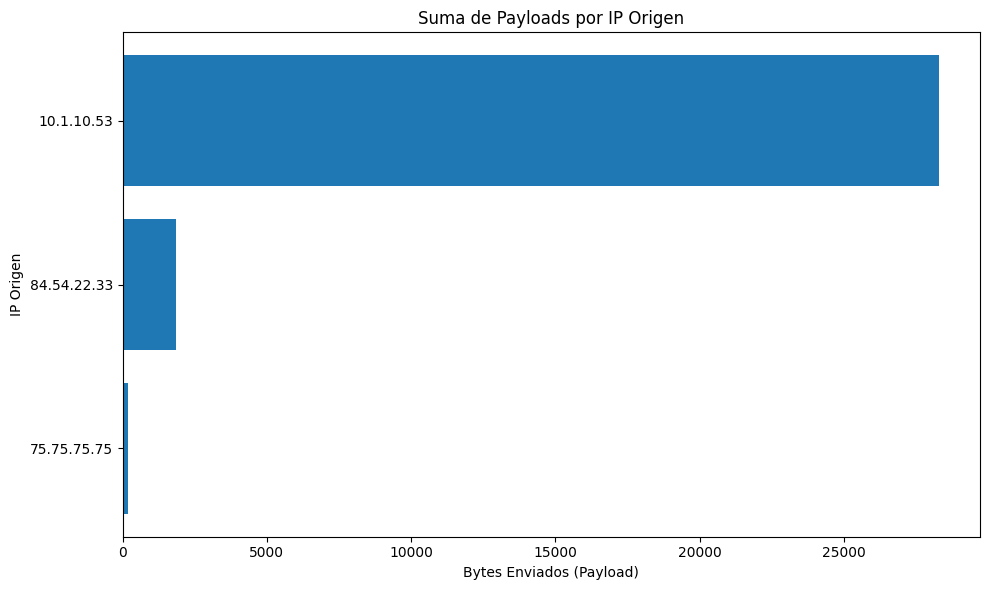

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(payload_df["IP Origen"], payload_df["Bytes Enviados"])
plt.xlabel("Bytes Enviados (Payload)")
plt.ylabel("IP Origen")
plt.title("Suma de Payloads por IP Origen")
plt.tight_layout()
plt.show()


Genere una gráfica de barras 2D horizontales, en el eje Y las IP destino, y en el eje X
la suma de los payloads (bytes) recibidos en dichas direcciones.

In [17]:
from collections import defaultdict

# Diccionario para guardar la suma de payloads por IP destino
payloads_por_ip_destino = defaultdict(int)

for pkt in paquetes:
    if pkt.haslayer("IP"):
        dst_ip = pkt["IP"].dst
        payload_size = len(pkt["IP"].payload)
        payloads_por_ip_destino[dst_ip] += payload_size


In [ ]:
payload_dst_df = pd.DataFrame(list(payloads_por_ip_destino.items()), columns=["IP Destino", "Bytes Recibidos"])
payload_dst_df = payload_dst_df.sort_values(by="Bytes Recibidos", ascending=True)


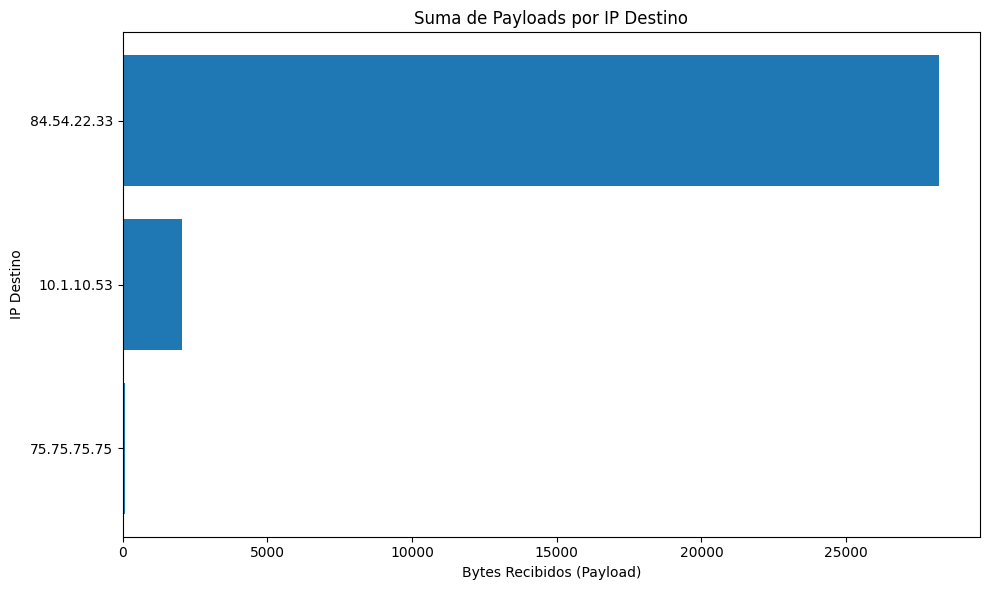

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(payload_dst_df["IP Destino"], payload_dst_df["Bytes Recibidos"])
plt.xlabel("Bytes Recibidos (Payload)")
plt.ylabel("IP Destino")
plt.title("Suma de Payloads por IP Destino")
plt.tight_layout()
plt.show()


Genere una gráfica de barras 2D horizontales, en el eje Y los puertos origen, y en el
eje X la suma de los payloads (bytes) enviados de dichos puertos.

In [20]:
from collections import defaultdict

# Diccionario para guardar la suma de payloads por puerto origen
payloads_por_puerto_origen = defaultdict(int)

for pkt in paquetes:
    if pkt.haslayer("IP") and hasattr(pkt, 'sport'):
        src_port = pkt.sport
        payload_size = len(pkt["IP"].payload)
        payloads_por_puerto_origen[src_port] += payload_size


In [21]:
payload_srcport_df = pd.DataFrame(
    list(payloads_por_puerto_origen.items()),
    columns=["Puerto Origen", "Bytes Enviados"]
)
payload_srcport_df = payload_srcport_df.sort_values(by="Bytes Enviados", ascending=True)


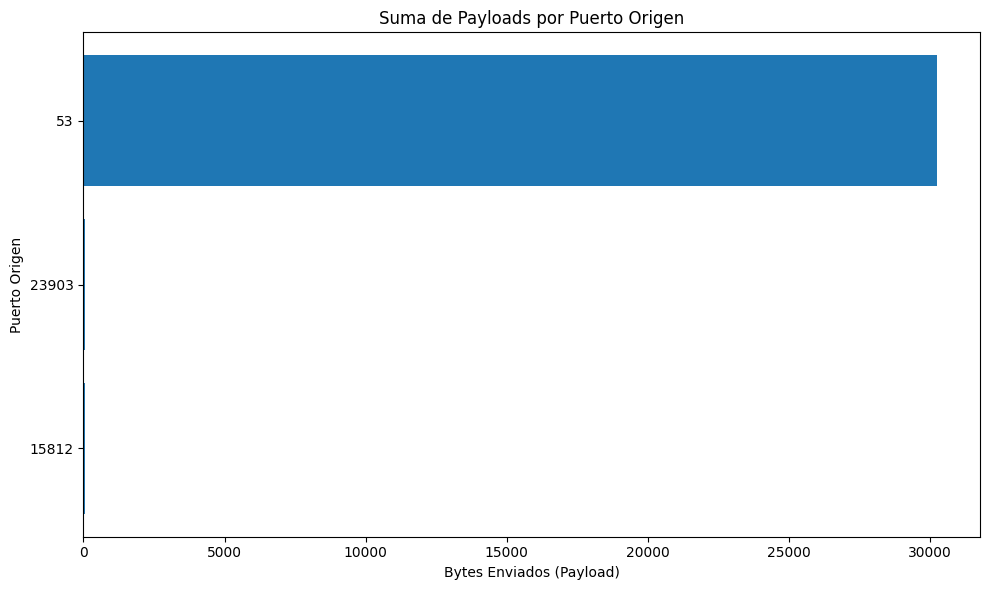

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(payload_srcport_df["Puerto Origen"].astype(str), payload_srcport_df["Bytes Enviados"])
plt.xlabel("Bytes Enviados (Payload)")
plt.ylabel("Puerto Origen")
plt.title("Suma de Payloads por Puerto Origen")
plt.tight_layout()
plt.show()


d. Genere una gráfica 2D de barras horizontales, en el eje Y los puertos destino, y en el
eje X la suma de los payloads (bytes) recibidos en dichos puertos

In [26]:
ip_origen_frecuente = df["Src Address"].value_counts().idxmax()
print("IP origen más frecuente:", ip_origen_frecuente)


IP origen más frecuente: 10.1.10.53


In [ ]:
from collections import defaultdict

payloads_por_segundo = defaultdict(int)

for pkt in paquetes:
    if pkt.haslayer("IP") and pkt["IP"].src == ip_origen_frecuente:
        timestamp = int(pkt.time)
        payload_size = len(pkt["IP"].payload)
        payloads_por_segundo[timestamp] += payload_size


In [28]:
tiempo_df = pd.DataFrame(
    list(payloads_por_segundo.items()),
    columns=["Tiempo (s)", "Bytes Enviados"]
)
tiempo_df = tiempo_df.sort_values(by="Tiempo (s)")


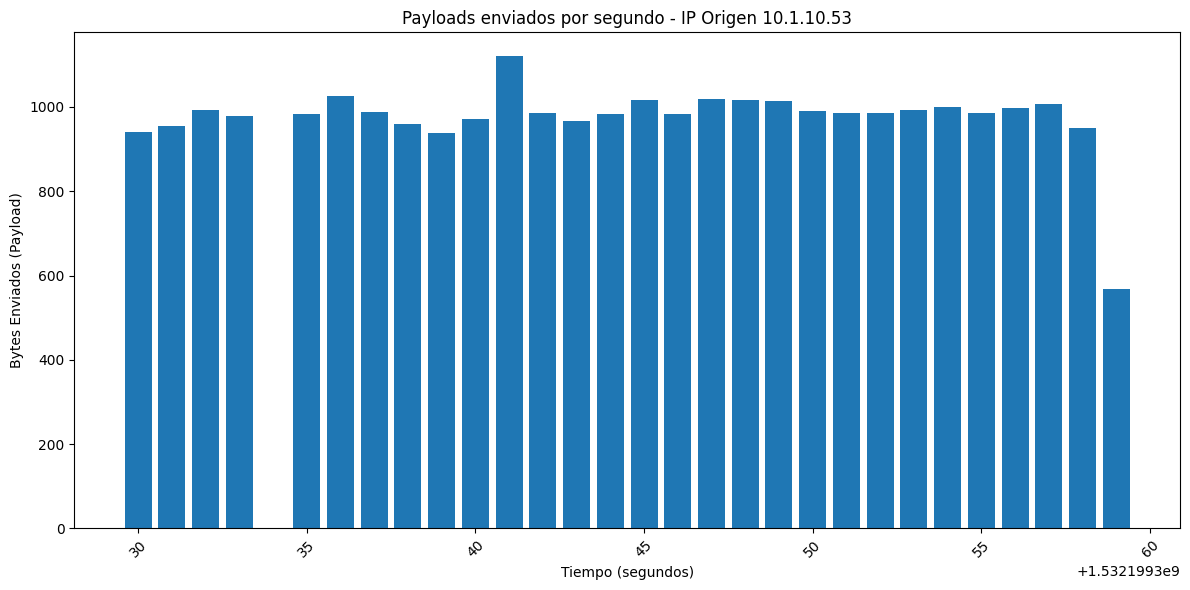

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(tiempo_df["Tiempo (s)"], tiempo_df["Bytes Enviados"])
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Bytes Enviados (Payload)")
plt.title(f"Payloads enviados por segundo - IP Origen {ip_origen_frecuente}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


f. Utilizando la información de las estadísticas y la información del comportamiento del
tráfico que las gráficas muestran, describa que es lo que está sucediendo. ¿Es común
el comportamiento?


No es comun. La cantidad de payloads que hay de una misma ip y puerto es inmensa comparada con el resto que hay. 

Investigación del payload
a. Cree un nuevo DF que incluya únicamente las conexiones con la dirección IP origen
más frecuente

In [30]:
ip_origen_frecuente = df["Src Address"].value_counts().idxmax()
print("IP origen más frecuente:", ip_origen_frecuente)


IP origen más frecuente: 10.1.10.53


In [31]:
df_frecuente = df[df["Src Address"] == ip_origen_frecuente].copy()
df_frecuente.head()


,Src Address,Dst Address,Src Port,Dst Port
0,10.1.10.53,84.54.22.33,53,53
2,10.1.10.53,84.54.22.33,53,53
4,10.1.10.53,84.54.22.33,53,53
6,10.1.10.53,84.54.22.33,53,53
8,10.1.10.53,84.54.22.33,53,53


b. Cree un nuevo DF que utilice el DF anterior con las columnas src, dst y payload y
agrúpelas por dst y la suma del payload

In [ ]:
datos_payload = []

for pkt in paquetes:
    if pkt.haslayer("IP") and pkt["IP"].src == ip_origen_frecuente:
        src_ip = pkt["IP"].src
        dst_ip = pkt["IP"].dst
        payload_size = len(pkt["IP"].payload)
        datos_payload.append({
            "Src Address": src_ip,
            "Dst Address": dst_ip,
            "Payload": payload_size
        })

df_payload = pd.DataFrame(datos_payload)


In [33]:
df_agrupado = df_payload.groupby("Dst Address")["Payload"].sum().reset_index()
df_agrupado = df_agrupado.sort_values(by="Payload", ascending=False)
df_agrupado.head()


,Dst Address,Payload
1,84.54.22.33,28211
0,75.75.75.75,90


c. Obtenga la IP destino que más ha intercambiado bytes con la IP más frecuente. Esta
IP es sospechosa por la cantidad de bytes intercambiados, entre todas las direcciones.

In [34]:
ip_sospechosa = df_agrupado.iloc[0]  # Primera fila ya que está ordenado de mayor a menor
print("IP destino sospechosa:", ip_sospechosa["Dst Address"])
print("Bytes intercambiados:", ip_sospechosa["Payload"])


IP destino sospechosa: 84.54.22.33
Bytes intercambiados: 28211


d. Cree un nuevo DF con la conversación entre la IP más frecuente y la IP sospechosa.

In [35]:
ip_frecuente = ip_origen_frecuente
ip_sospechosa = ip_sospechosa["Dst Address"]


df_conversacion = df_payload[
    ((df_payload["Src Address"] == ip_frecuente) & (df_payload["Dst Address"] == ip_sospechosa)) |
    ((df_payload["Src Address"] == ip_sospechosa) & (df_payload["Dst Address"] == ip_frecuente))
].copy()

df_conversacion.head()

,Src Address,Dst Address,Payload
0,10.1.10.53,84.54.22.33,941
1,10.1.10.53,84.54.22.33,955
2,10.1.10.53,84.54.22.33,992
3,10.1.10.53,84.54.22.33,978
4,10.1.10.53,84.54.22.33,983


e. Obtenga los payloads del DF del inciso anterior, y añada cada uno en un array.

In [40]:
payloads_array = []

for pkt in paquetes:
    if pkt.haslayer("IP"):
        src = pkt["IP"].src
        dst = pkt["IP"].dst

        if (
            (src == ip_frecuente and dst == ip_sospechosa) or
            (src == ip_sospechosa and dst == ip_frecuente)
        ):
            # Extraemos el payload en bytes
            payload = bytes(pkt["IP"].payload)
            payloads_array.append(payload)


f. Muestre el contenido del array

In [41]:
print(f"Cantidad de payloads encontrados: {len(payloads_array)}")
print("Primeros 3 payloads:")
for i, p in enumerate(payloads_array[:3]):
    print(f"\nPayload {i+1}:")
    print(p)
payloads_texto = []

for i, payload in enumerate(payloads_array):
    try:
        texto = payload.decode("utf-8", errors="replace")  # reemplaza caracteres inválidos
        payloads_texto.append(texto)
    except Exception as e:
        payloads_texto.append(f"[Error al decodificar: {e}]")
print("Primeros 3 payloads convertidos a texto:\n")
for i, p in enumerate(payloads_texto[:3]):
    print(f"Payload {i+1}:\n{p}\n{'-'*60}")


Cantidad de payloads encontrados: 58
Primeros 3 payloads:

Payload 1:
b'\x005\x005\x03\xad\xf6\x0e\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbdPNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01b\x00\x00\x00\xef\xbf\xbd\x08\x06\x00\x00\x00(\xef\xbf\xbdTR\x00\x00:\xef\xbf\xbdIDATx\xef\xbf\xbd\xef\xbf\xbd\t|T\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd;K\x12\x08;\x08\xef\xbf\xbd\nE\xef\xbf\xbd\xef\xbf\xbd$\x19\xef\xbf\xbd\xef\xbf\xbdZi\xdf\xaa-\xef\xbf\xbd;N2\xef\xbf\xbd\xef\xbf\xbdV\xef\xbf\xbdV\xef\xbf\xbda\xef\xbf\xbdZ\x11!\xef\xbf\xbd\xef\xbf\xbd\x01\xdc\xbbik[\xef\xbf\xbd.ok\xef\xbf\xbde\xef\xbf\xbd\x01\\\xef\xbf\xbd\xef\xbf\xbd]\xef\xbf\xbd-\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdd\xef\xbf\xbd\x08\xef\xbf\xbd\x08\xef\xbf\xbd\xef\xbf\xbdg\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd<\xef\xbf\xbd\xef\xbf\xbdL\x12\xef\xbf\xbd$3wf\xef\xbf\xbd\xef\xbf\xbd\x02<_\r\xef\xbf\xbdY\xef\xbf\xbdr\xef\xbf\xbd\xef\xbf\xbdy\xef\xbf\xbd\xef\xbf\xbd\xef

g. Observe los primeros bytes del contenido, ¿encuentra algún tipo de dato que no haga
sentido que se envíe al puerto destino? Describa lo que encontró.

si, ningun dato hace sentido porque estan codificafos. ademas, lo que fue enviadoson imagenes o algun otro tipo de dato que no es texto por lo que no se puede decodificar y leer.